In [3]:
import os 
import gym
import torch
from stable_baselines3 import PPO
import math
import numpy as np
from gym import spaces
import pygame
from gym.spaces import Tuple
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import tensorflow as tf
import random

In [4]:
def calc_distance(pos1, pos2):
    """
    Calculates the distance between two positions using the Euclidean distance formula.
    """
    x1, y1 = pos1
    x2, y2 = pos2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
def calculate_signal_strength(agent, basestation):
    base_station_params = {
            (3, 3):(20, 2, 4),
            (15, 3):(20, 2, 4),
            (27, 3):(20, 2, 4),
            (3, 15):(10, 3, 3),
            (15, 15):(10, 3, 3),
            (27, 15):(10, 3, 3),
            (3, 27):(15, 1, 5),
            (15, 27):(15, 1, 5),
            (27, 27):(15, 1, 5),
            (3, 39):(15, 1, 5),
            (15, 39):(15, 1, 5),
            (27, 39):(15, 1, 5),
            (3, 51):(15, 1, 5),
            (15, 51):(15, 1, 5),
            (27, 51):(5, 1, 5),
            
        }
    
        
     # calculate the signal strength using this formula
    Pt, Gt, Gr = base_station_params[basestation]
    d = calc_distance(agent, basestation)
    return Pt*Gt*Gr/((d+1)**2)
def calculate_SINR(agent,basestation):
    
    base_station_params = {
            (3, 3):(20, 2, 4),
            (15, 3):(20, 2, 4),
            (27, 3):(20, 2, 4),
            (3, 15):(10, 3, 3),
            (15, 15):(10, 3, 3),
            (27, 15):(10, 3, 3),
            (3, 27):(15, 1, 5),
            (15, 27):(15, 1, 5),
            (27, 27):(15, 1, 5),
            (3, 39):(15, 1, 5),
            (15, 39):(15, 1, 5),
            (27, 39):(15, 1, 5),
            (3, 51):(15, 1, 5),
            (15, 51):(15, 1, 5),
            (27, 51):(5, 1, 5),  
        }
    signal_power = calculate_signal_strength(agent,basestation)
    interference_power = 0
    noise_power = -174
    signal_distance = calc_distance(agent, basestation)
    for bs,(Pt, Gt, Gr) in base_station_params.items():
        if bs != basestation:
            interference_distance = calc_distance(agent, bs)
            interference_power += Pt + Gt + Gr-(10*math.log10(interference_distance+1))

    SINR = signal_power - (interference_power + noise_power)
    return SINR 
def calculate_datarate(SINR):
    bandwidth = 10
    bits_per_symbol = 4
    snr_linear = 10**(SINR/10)
    max_data_rate = bandwidth * math.log2(1 + snr_linear) * bits_per_symbol 
    return max_data_rate

In [5]:
class GridEnvironment(gym.Env):
    
    def __init__(self, ranges):
        """
        Initializes the environment with a grid size, base station positions, and ranges.
        """
        self.grid_size = (40, 60)
        self.base_stations=  [(3, 3),(15,3),(27,3), (3, 15),(15,15),(27,15), (3, 27),(15,27),(27,27), (3, 39),(15,39),(27,39), (3, 51), (15, 51), (27, 51)]
        self.ranges = ranges
        self.agent_position = (20, 30)# initial position of the agent
        self.previous_action = None # previous base station selected by the agent
        self.new_signal_strength = 0
        self.SINR = 0
        self.selection_space = [bs for i, (bs, r) in enumerate(zip(self.base_stations, self.ranges)) if calc_distance(self.agent_position, bs) <= r]
        self.new_action = random.choice(self.selection_space)
        self.action_space = gym.spaces.Discrete(15)
        self.handover_num = 0        
        self.basestation_selection = random.choice(self.selection_space)
        self.state_space = np.concatenate((np.array(self.agent_position),np.array(self.basestation_selection),np.array(self.new_signal_strength),np.array(self.SINR),np.array(self.handover_num)),axis=None)
        self.observation_space = spaces.Box(low=0, high=60, shape=(self.state_space.shape[0],), dtype=np.float32)
        self.reward = 0
        self.frequency = 28e9
        
        self.base_station_params = {
            (3, 3):(20, 2, 4),
            (15, 3):(20, 2, 4),
            (27, 3):(20, 2, 4),
            (3, 15):(10, 3, 3),
            (15, 15):(10, 3, 3),
            (27, 15):(10, 3, 3),
            (3, 27):(15, 1, 5),
            (15, 27):(15, 1, 5),
            (27, 27):(15, 1, 5),
            (3, 39):(15, 1, 5),
            (15, 39):(15, 1, 5),
            (27, 39):(15, 1, 5),
            (3, 51):(15, 1, 5),
            (15, 51):(15, 1, 5),
            (27, 51):(5, 1, 5),
            
        }
    
    def reset(self):
        """
        Resets the environment and returns the initial state.
        """
        self.done = False
#         self.agent_position = (20,30) # set the agent position to a random position on the map
        self.previous_action = None # reset the previous action to None
        self.basestation_selection = random.choice(self.selection_space)
        self.new_signal_strength = self.calculate_signal_strength(self.new_action)
        self.SINR = self.calculate_SINR(self.new_action)
        self.handover_num = 0
        self.reward = 0
        self.state_space = np.concatenate((np.array(self.agent_position),np.array(self.basestation_selection),np.array(self.new_signal_strength),np.array(self.SINR),np.array(self.handover_num)),axis=None)
        self.selection_space = [bs for i, (bs, r) in enumerate(zip(self.base_stations, self.ranges)) if calc_distance(self.agent_position, bs) <= r]
        return self.state_space

    def take_action(self, action):
        # update the bs selection
        
        self.basestation_selection = action
        # choose a random direction
#         direction = random.choice(["up", "down", "left", "right"])

#         # update the agent position based on the chosen direction
#         if direction == "up":
#             self.agent_position = (self.agent_position[0] - 1, self.agent_position[1])
#         elif direction == "down":
#             self.agent_position = (self.agent_position[0] + 1, self.agent_position[1])
#         elif direction == "left":
#             self.agent_position = (self.agent_position[0], self.agent_position[1] - 1)
#         elif direction == "right":
#             self.agent_position = (self.agent_position[0], self.agent_position[1] + 1)
        # check if the agent has gone outside the map
        
        if self.agent_position[0] <0 or self.agent_position[0] >40 or self.agent_position[1] < 0 or self.agent_position[1] > 60:
            self.reset()

        # update the action space to only contain the base stations within range
        self.selection_space = [bs for i, (bs, r) in enumerate(zip(self.base_stations, self.ranges)) if calc_distance(self.agent_position, bs) <= r]
#         self.state_space = np.concatenate((np.array(self.agent_position),np.array(self.basestation_selection),np.array(self.new_signal_strength),np.array(self.SINR)),axis=None)
                              
    
    def calculate_signal_strength(self, action):
        
         # calculate the signal strength using this formula
        Pt, Gt, Gr = self.base_station_params[self.new_action]
        d = calc_distance(self.agent_position, self.new_action)
        return Pt*Gt*Gr/((d+1)**2)
        
    def calculate_SINR(self, action):
        signal_power = self.new_signal_strength
        interference_power = 0
        noise_power = -174
        signal_distance = calc_distance(self.agent_position, action)
        for bs,(Pt, Gt, Gr) in self.base_station_params.items():
            if bs != action:
                interference_distance = calc_distance(self.agent_position, bs)
                interference_power += Pt + Gt + Gr-(10*math.log10(interference_distance+1))
                                        
        self.SINR = signal_power - (interference_power + noise_power)
        return self.SINR  
    
    def get_reward(self, action):

        threshold = 120
        if self.previous_action is not None and self.previous_action != action:
            #handover happens
            self.reward -= 5
            self.handover_num = 1
            if self.new_signal_strength > self.state_space[4]:
                self.reward += 3
                if self.SINR > threshold:
                    self.reward += 6
        else: 
            self.handover_num = 0
            self.reward += 10
            
            if self.new_signal_strength > self.state_space[4]:
                
                self.reward += 3
                if self.SINR > threshold:
                    self.reward += 6
        self.basestation_selection = action
#         return self.reward

    def step(self, action):
        self.reward = 0
        
        if action == 0:
            self.new_action = self.base_stations[0]
        elif action == 1:
            self.new_action = self.base_stations[1]
        elif action == 2:
            self.new_action = self.base_stations[2]
        elif action == 3:
            self.new_action = self.base_stations[3]
        elif action == 4:
            self.new_action = self.base_stations[4]
        elif action == 5:
            self.new_action = self.base_stations[5]
        elif action == 6:
            self.new_action = self.base_stations[6]
        elif action == 7:
            self.new_action = self.base_stations[7]
        elif action == 8:
            self.new_action = self.base_stations[8]
        elif action == 9:
            self.new_action = self.base_stations[9]
        elif action == 10:
            self.new_action = self.base_stations[10]
        elif action == 11:
            self.new_action = self.base_stations[11]
        elif action == 12:
            self.new_action = self.base_stations[12]
        elif action == 13:
            self.new_action = self.base_stations[13]
        elif action == 14:
            self.new_action = self.base_stations[14]
            
        if self.new_action not in self.selection_space:
            self.reset()
            self.done = True
            
            return self.state_space, -100, self.done, {}
        if self.agent_position[0] <0 or self.agent_position[0] >40 or self.agent_position[1] < 0 or self.agent_position[1] > 60:
            self.reset()
            return self.state_space, -1,False, {}
        self.take_action(self.new_action)
        # take action and get the current state and done flag
        self.new_signal_strength = self.calculate_signal_strength(self.new_action)
        self.SINR = self.calculate_SINR(self.new_action)
#         self.state_space = np.concatenate((np.array(self.agent_position),np.array(self.basestation_selection),np.array(self.new_signal_strength),np.array(self.SINR)),axis=None)
        # get the reward
        self.get_reward(self.new_action)
#         reward = self.get_reward(self.new_action)
        
        # update previous action
        self.previous_action = self.basestation_selection
        # update the signal strength
        
        self.state_space = np.concatenate((np.array(self.agent_position),np.array(self.basestation_selection),np.array(self.new_signal_strength),np.array(self.SINR),np.array(self.handover_num)),axis=None)
        observation = np.concatenate((np.array(self.agent_position),np.array(self.basestation_selection),np.array(self.new_signal_strength),np.array(self.SINR),np.array(self.handover_num)),axis=None)
        
        # render the environment
        self.render()

        # return the state, reward, done flag, and an empty dictionary
        return observation, reward, self.done, {}


    def render(self, mode='human'):
        # initialize Pygame
        pygame.init()
        # set the window size
        screen = pygame.display.set_mode((400, 600))
        # set the window title
        pygame.display.set_caption("Grid Environment")
        # set the background color to white
        screen.fill((255, 255, 255))
        # draw the grid
        for i in range(41):
            pygame.draw.line(screen, (0, 0, 0), (i*10, 0), (i*10, 600))
        for i in range(61):
            pygame.draw.line(screen, (0, 0, 0), (0, i*10), (400, i*10))
        # draw the base stations
        for bs in self.base_stations:
            pygame.draw.circle(screen, (0, 0, 255), (bs[0]*10+5, bs[1]*10+5), 5)
        
        # draw the agent
        pygame.draw.circle(screen, (255, 0, 0), (self.agent_position[0]*10+5, self.agent_position[1]*10+5), 5)
        # display the action space
        font = pygame.font.Font(None, 36)
        text = font.render(f"Action Space: {self.selection_space}", True, (0, 0, 0))
        screen.blit(text, (10, 10))
        # display the agent position
        text = font.render(f"Agent Position: {self.agent_position}", True, (0, 0, 0))
        screen.blit(text, (10, 50))
        # display the accumulated reward
        text = font.render(f"Reward: {self.reward}", True, (0, 0, 0))
        screen.blit(text, (10, 90))
        # update the screen
        if mode == 'human':
          # Update the display
          pygame.display.flip()
        elif mode == 'rgb_array':
          # Return the rendered image as a NumPy array
          return np.array(pygame.surfarray.array3d(screen))


        
    def close(self):
        # Close the pygame window
        pygame.display.quit()

        # Shut down pygame
        pygame.quit()

In [316]:
DQN_path = os.path.join('Training', 'Saved Models', 'DQN_Model_300000with20482')

In [6]:
PPO_path = os.path.join('Training', 'Saved Models', 'PPO_Model_300000')

In [232]:
A2C_path = os.path.join('Training', 'Saved Models', 'A2C_Model_300000')

# new test 

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


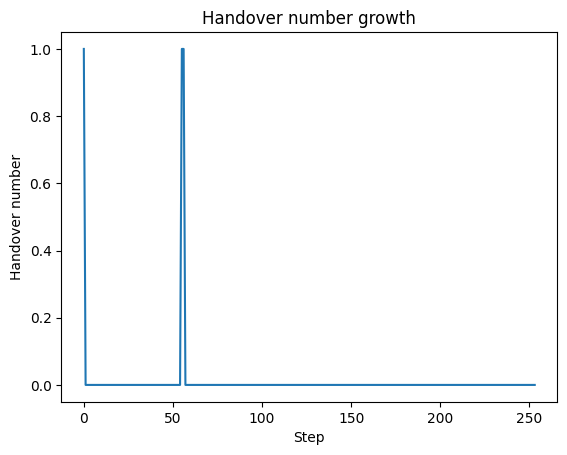

Average handover number: 3
average SINR 81.3809448032285
datarate 1081.3665890128627


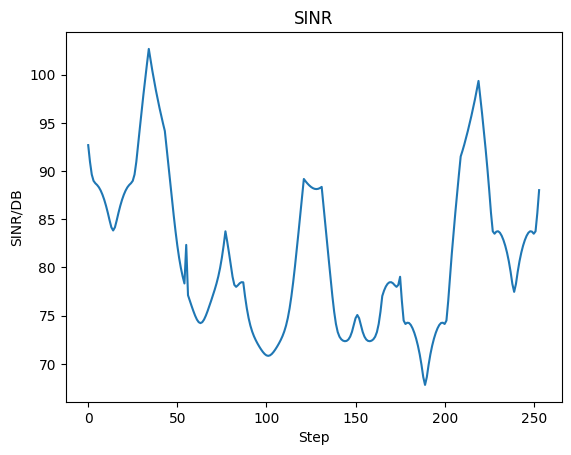

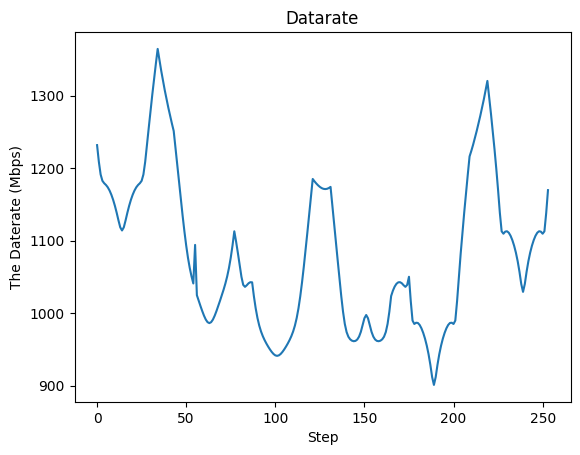

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
env = GridEnvironment([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,15])
model = PPO.load(PPO_path, env= env)
handover_count = []
handover_count2plt = []
SINR = 0
SINR_count = []
SINR_count2plt= []
datarate_count = []
datarat_count2plt = []

# Define the fixed route for the agent
fixed_route = []
current_x, current_y = 1, 1
x_step, y_step = 1, 1

destinations = [(35, 1), (35, 10), (1, 10), (1, 20), (35, 20), (35, 30), (1, 30), (1, 40), (35, 40), (35, 50), (1, 50)]

for destination in destinations:
    while current_x != destination[0] or current_y != destination[1]:
        fixed_route.append((current_x, current_y))
        if current_x < destination[0]:
            current_x += x_step
        elif current_x > destination[0]:
            current_x -= x_step
        if current_y < destination[1]:
            current_y += y_step
        elif current_y > destination[1]:
            current_y -= y_step

fixed_route.append(destination)


# Initialize the environment
# print(fixed_route)

# Initialize the state


# Loop through the fixed route

state = env.reset()
done = False
env.handover_num = 0
handover = 0
handover_2plt=0
env.agent_position = fixed_route[0]
env.selection_space = [bs for i, (bs, r) in enumerate(zip(env.base_stations, env.ranges)) if calc_distance(env.agent_position, bs) <= r]
newaction = random.choice(env.selection_space)
oldaction = random.choice(env.selection_space)

for position in fixed_route:
    # Update the agent position to the new position in the route
    env.agent_position = position

    # Get the action from the model
    a, _ = model.predict(state)
    
    # Take the action in the environment and get the new state, reward, done flag, and empty dictionary
    state, reward, done, _ = env.step(a)
#     if newaction != oldaction:
#         handover_count.append(1)
#     else: handover_count.append(0)
    if a == 0:
        newaction = env.base_stations[0]
    elif a == 1:
        newaction = env.base_stations[1]
    elif a == 2:
        newaction = env.base_stations[2]
    elif a == 3:
        newaction = env.base_stations[3]
    elif a == 4:
        newaction = env.base_stations[4]
    elif a == 5:
        newaction = env.base_stations[5]
    elif a == 6:
        newaction = env.base_stations[6]
    elif a == 7:
        newaction = env.base_stations[7]
    elif a == 8:
        newaction = env.base_stations[8]
    elif a == 9:
        newaction = env.base_stations[9]
    elif a == 10:
        newaction = env.base_stations[10]
    elif a == 11:
        newaction = env.base_stations[11]
    elif a == 12:
        newaction = env.base_stations[12]
    elif a == 13:
        newaction = env.base_stations[13]
    elif a == 14:
        newaction = env.base_stations[14]
    elif a == 15:
        newaction = env.base_stations[15]
#     print("old",oldaction)
#     print("new",newaction)
#     newaction = random.choice(env.selection_space)
    if newaction != oldaction:
        handover_count.append(1)
    else: handover_count.append(0)
    
    SINR =calculate_SINR(position, newaction)
    SINR_count.append(SINR)
    datarate = calculate_datarate(SINR)
    datarate_count.append(datarate)
    oldaction = newaction



average_handover_num = np.sum(handover_count)
average_SINR = np.mean(SINR_count)
average_datarate = np.mean(datarate_count)




    
    
env.close()
plt.plot(handover_count)
plt.xlabel("Step")
plt.ylabel("Handover number")
plt.title("Handover number growth")
plt.savefig("Handover number growth beforetraining.png")
plt.show()

print("Average handover number:", average_handover_num)
print("average SINR",average_SINR)
print("datarate",average_datarate)

plt.plot(SINR_count)
plt.xlabel("Step")
plt.ylabel("SINR/DB")
plt.title("SINR")
plt.savefig("SINR.png")
plt.show()

plt.plot(datarate_count)
plt.xlabel("Step")
plt.ylabel("The Daterate (Mbps)")
plt.title("Datarate")
plt.savefig("daterate.png")
plt.show()